In [4]:
#@title Imports
import pandas as pd
import matplotlib.pyplot as plt
import os 

plt.rcParams['figure.figsize'] = [6,4]#[15, 10]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 10})

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-pastel')

plt.rcParams['figure.facecolor'] = 'white'

from google.colab import drive 
drive.mount('/content/gdrive')

# path = 'gdrive/My Drive/Doutorado/reinforcement_learning/results/'
path = 'gdrive/My Drive/Doutorado/reinforcement_learning/super_computing_paper/results/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Parametrization

In [ ]:
#@title Parametrization

import shutil

algorithms = ['PPO2']#,'A2C']
tmp_path = path+'parametrization/'

delete_old_files = False
save_files = False

for algorithm in algorithms:
  alg_path = tmp_path+algorithm+'/'
  parameters_folders = os.listdir(alg_path)
  parameters_folders = sorted(parameters_folders)

  if os.path.exists(alg_path+'plots/') and delete_old_files:
    shutil.rmtree(alg_path+'plots/') # to remove old files
  
  if not os.path.exists(alg_path+'plots/') and save_files: 
    os.makedirs(alg_path+'plots/')

  results = {}
  alphas = []
  gammas = []
  for folder in parameters_folders:
    filename = alg_path+folder+'/'+algorithm+'_cumulative_rewards.csv'
    
    if os.path.exists(filename):
      df = pd.read_csv(filename)
      df = df[df.columns[:30]]
      

      label = folder.split('_')
      
      gamma = float(label[1]) # discount factor
      alpha = float(label[4]) # learning rate
      results[(gamma,alpha)] = df.mean(axis=1)
      
      if gamma not in gammas:
        gammas.append(gamma)
      if alpha not in alphas:
        alphas.append(alpha)
      # plt.plot(results[(float(label[1]),float(label[4]))],label = 'γ='+label[1]+' α='+label[4])
  
  for learning_rate in alphas:
    for gamma in gammas:
      if (gamma,learning_rate) in results:
        plt.plot(results[(gamma,learning_rate)],label= 'γ='+str(gamma))
    
    plt.ylim(plt.ylim()[0],100000)
    plt.title('α='+str(learning_rate))
    plt.ylabel('Cumulative Reward')
    plt.xlabel('Steps')
    
    
    plt.legend(loc='best', shadow=True, fontsize='medium')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='small')
    if save_files:
      plt.savefig(alg_path+'plots/'+'g='+str(gamma)+'_a='+str(learning_rate)+'.png',bbox_inches='tight')
      plt.clf()
    else:
      plt.show()


ax = plt.gca()  # get the current axes
ax.relim()      # make sure all the data fits
ax.autoscale()  # auto-scale
print('Done!') 

# Scenario Variation

In [ ]:
#title Scenario Variation
import shutil
import seaborn as sns
# sns.set(style="ticks", palette="pastel")

def generate_box_plots(algorithms,tmp_path,metric,evaluation_type,save_files,delete_old_files):
  
  if os.path.exists(tmp_path+'plots/') and delete_old_files:
    shutil.rmtree(tmp_path+'plots/') # to remove old files
  
  if not os.path.exists(tmp_path+'plots/') and save_files: 
    os.makedirs(tmp_path+'plots/')

  ## columns=['algorithm','resources','avg_energy_consumption','acc_rate_sla_ok','acc_rate_sla_broken','total_acc_rate']
  # columns=['Algorithm','Resources','Average Energy Consumption','Cumulative Energy Consumption','Acceptation Rate','Acceptation Rate (SLA broken)','Total Acceptation Rate']
  # total_df = pd.DataFrame(columns=columns)
  total_df = pd.DataFrame()

  if evaluation_type == 'resources':
    path_evaluation = '/resources/'
    xaxis = 'Resources (in units)'
  
  elif evaluation_type == 'customers':
    path_evaluation = '/customers_number/'
    xaxis = 'Customers Number'
  
  else:
    path_evaluation = '/availability_threshold/'
    xaxis = 'Availability Threshold (in %)'

  for algorithm in algorithms:
    algorithm_path = tmp_path+algorithm+path_evaluation
    
    paths = os.listdir(algorithm_path)
    for r_path in paths:
      if r_path == '20':
        continue

      df = pd.read_csv(algorithm_path+r_path+'/'+algorithm+'_metrics.csv')
      # df = df.head(30)
      # print(df.shape)
      
      tmp_df = pd.DataFrame()
      
      tmp_df['Algorithm'] = [algorithm]* df.shape[0]
      if evaluation_type == 'availability':
        tmp_df[xaxis] = [str(r_path)]* df.shape[0]
      else:
        tmp_df[xaxis] = [int(r_path)]* df.shape[0]
      tmp_df['Average Energy Consumption (W)'] = df['avg_energy_consumption']
      tmp_df['Acceptance Rate (%)'] = df['sucess']/df['sfc_requests']
      tmp_df['Acceptance Rate (SLA broken) (%)'] = df['sucess_sla_broken']/df['sfc_requests']
      tmp_df['Total Acceptance Rate (%)'] = (df['sucess_sla_broken']+df['sucess'])/df['sfc_requests']
      # Cumulative Energy Consumption (W)
      tmp_df['Energy Consumption (W)'] = df['avg_energy_consumption']*(df['sucess_sla_broken']+df['sucess'])

      total_df = total_df.append(tmp_df)

      print('-----------------------------------')
      print(algorithm,'evaluation_type:',evaluation_type,'variation:',r_path)
      print(tmp_df['Acceptance Rate (%)'].describe())
      print(tmp_df['Energy Consumption (W)'].describe())


  
  sns_plot = sns.boxplot(x=xaxis, y=metric,hue='Algorithm',
              palette=["m", "g"],
              data=total_df)

  sns_plot = sns_plot.get_figure()

  if save_files:
    sns_plot.savefig(tmp_path+'plots/'+evaluation_type+'_'+metric+'.png',bbox_inches='tight')
    sns_plot.clf()
  else:
    sns_plot.show()



save_files = True
delete_old_files = False

algorithms = ['PPO2','A2C']#,'GREEDY']
tmp_path = path+'scenario_variation/'

# metric = 'Total Acceptation Rate'
# metric = 'Average Energy Consumption'
# metric = 'Acceptation Rate (SLA broken)'
metric_list = ['Acceptance Rate (%)','Total Acceptance Rate (%)','Average Energy Consumption (W)','Energy Consumption (W)','Acceptance Rate (SLA broken) (%)']

# evaluation_type = 'customers' # 'customers'
evaluation_type_list = ['customers', 'resources']#, 'availability']
# evaluation_type_list = ['resources']#, 'availability']

# metric_list = ['Total Acceptation Rate']
# evaluation_type_list = ['availability']

for metric in metric_list:
  for evaluation_type in evaluation_type_list:
    generate_box_plots(algorithms,tmp_path,metric,evaluation_type,save_files,delete_old_files)

-----------------------------------
PPO2 evaluation_type: customers variation: 4
count    30.000000
mean      0.969841
std       0.010951
min       0.935484
25%       0.969697
50%       0.971825
75%       0.976744
max       0.981818
Name: Acceptance Rate (%), dtype: float64
count       30.000000
mean      7091.848000
std       1497.393459
min       5052.240000
25%       5999.535000
50%       6876.660000
75%       8069.550000
max      10244.820000
Name: Energy Consumption (W), dtype: float64
-----------------------------------
PPO2 evaluation_type: customers variation: 6
count    30.000000
mean      0.968595
std       0.017139
min       0.925926
25%       0.962264
50%       0.974199
75%       0.982456
max       0.985915
Name: Acceptance Rate (%), dtype: float64
count       30.000000
mean     10336.041000
std       1795.447237
min       6666.150000
25%       9543.120000
50%      10385.160000
75%      11227.200000
max      13472.640000
Name: Energy Consumption (W), dtype: float64
--------

<Figure size 1200x800 with 0 Axes>

# Scenario Variation 2

In [2]:
!pip install openpyxl xlsxwriter xlrd

     |████████████████████████████████| 153kB 2.7MB/s 


In [ ]:
#@title Acceptance Ratio x Time

results_path = path + 'scenario_variation/'

parameters = ['customers_number']
algorithm = 'A2C'

metrics = ['acceptance_ratio']

for param in parameters:
  if param == 'customers_number':
    sheets = [10,20,30,40]

  for metric in metrics:
    for sheet in sheets:
      # PPO2_customers_number_acceptance_ratio.xlsx
      # print(results_path+algorithm+'_'+param+'_'+metric+'.xlsx')
      name_file = results_path+algorithm+'_'+param+'_'+metric+'.xlsx'
      data = pd.read_excel(name_file,sheet_name=str(sheet))
      data['mean'] = data.mean(axis=1)
      plt.plot(data['mean'][:80], label= sheet)
      #print(data.head())

plt.legend(loc="best")


PPO2 Energy consumption → mean: 136.81225458219703 SD: 0.7365706247808851
A2C Energy consumption → mean: 137.82036345117203 SD: 0.7163325580929977
GREEDY Energy consumption → mean: 140.33999999999895 SD: 1.6095062610456298e-13


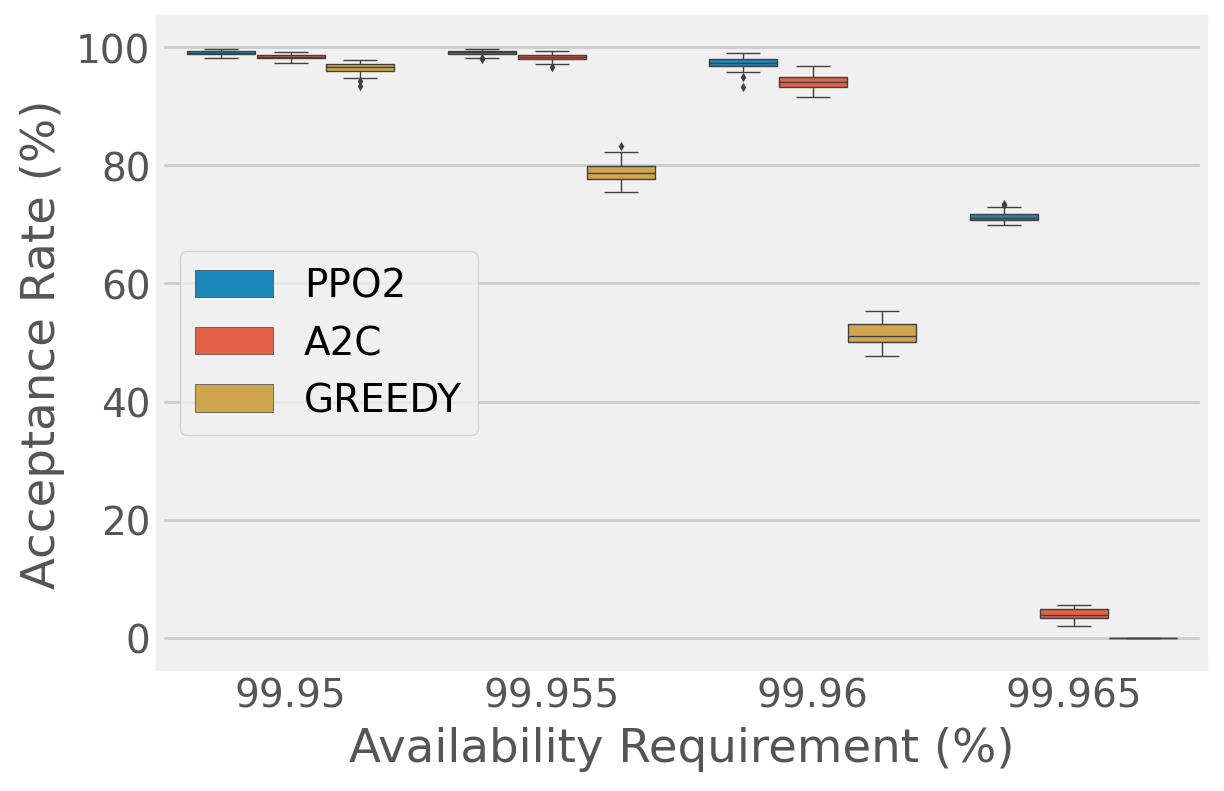

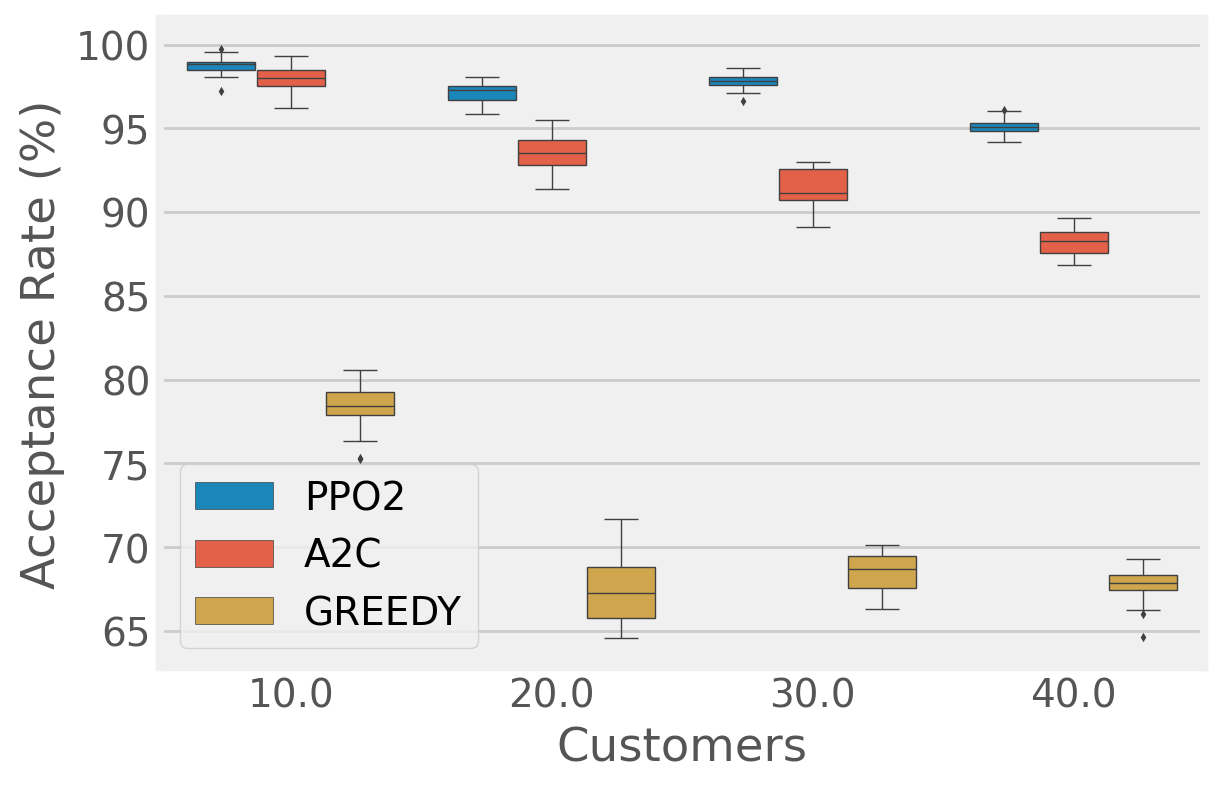

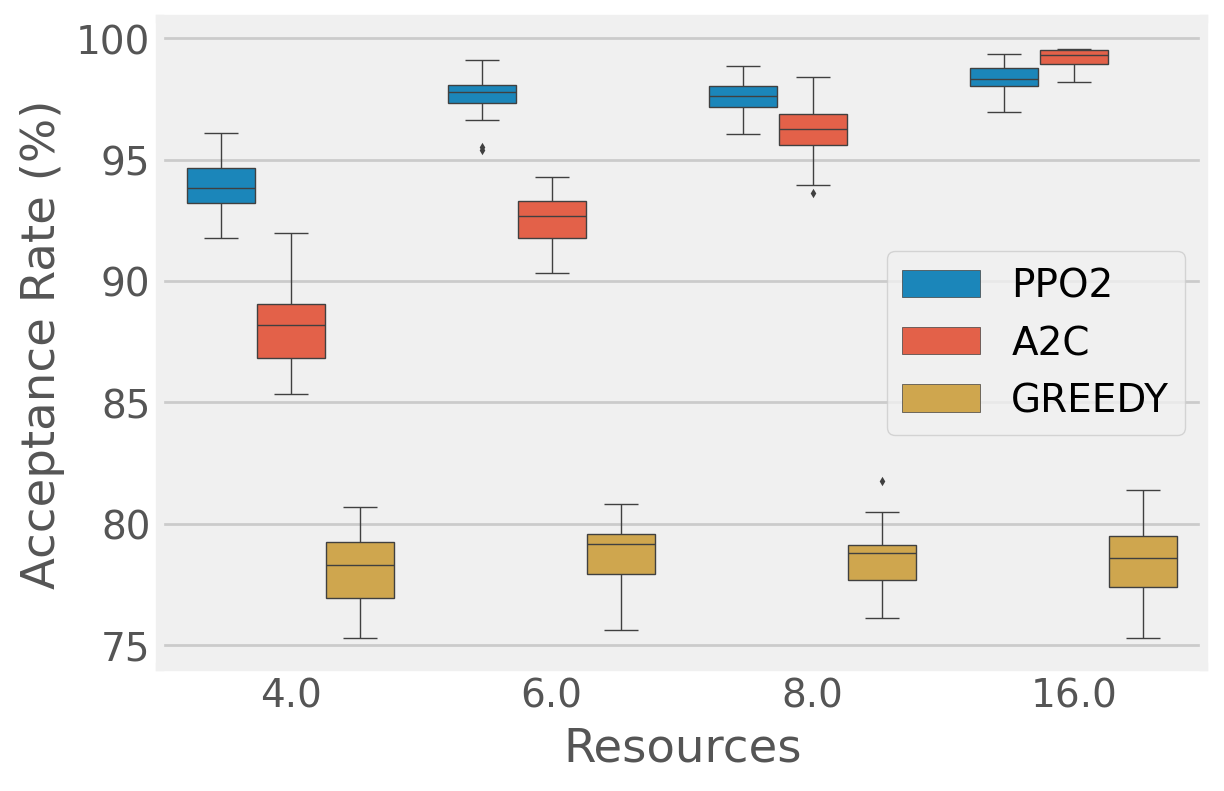

<Figure size 1200x800 with 0 Axes>

In [5]:
import seaborn as sns

results_path = path + 'scenario_variation/'
# PPO2_availability_threshold_results.xlsx



metrics = ['availability_threshold','customers_number','resources']
# metrics = ['availability_threshold']
# metrics = ['customers_number']
#metrics = ['resources']

for metric in metrics:
  algorithms = ['PPO2','A2C','GREEDY']
  # algorithms = ['PPO2','A2C']
  # algorithms += ['Greedy_rand']
  # algorithms += ['Greedy_rand','Greedy_max']

  if metric == 'availability_threshold':
    metric_name = 'Availability Requirement (%)'
    # algorithms.append('GREEDY')
    increase_factor = 100
  elif metric == 'customers_number':
    metric_name = 'Customers'
    increase_factor = 1
  elif metric == 'resources':
    metric_name = 'Resources'
    increase_factor = 1
  
  df_boxplot = pd.DataFrame()

  for algorithm in algorithms:
    name_file = results_path+algorithm+'_'+metric+'_'+'results.xlsx'
    df = pd.read_excel(name_file,sheet_name=None)
    
    for sheet in list(df.keys()): # getting all sheets
      # if float(sheet) == 0.99965 or float(sheet) == 0.9996:
      #   continue
      data = df[sheet]
      data['Energy Consumption per SFC (W)'] = data['energy_consumption']/data['sfc_sucess']

      data['Acceptance Rate (%)'] = (data['sfc_sucess']/data['sfcs_number'])*100
      # print(algorithm,sheet,':',data['Acceptance Rate (%)'].describe())
      # print(metric+':',sheet,'→','acceptance ratio:',data['acceptance_ratio'].mean(),'energy:',data['energy_consumption'].mean())
      data = data.rename(columns={'energy_consumption':'Energy Consumption (W)'})
      
      data['Algorithm'] = [algorithm]*data.shape[0]
      data[metric_name] = [round(float(sheet)*increase_factor,3)]*data.shape[0]

      if float(sheet) == 0.99955 and metric == 'availability_threshold':
        # print(algorithm,data['Energy Consumption per SFC (W)'].describe())
        print(algorithm,'Energy consumption → mean:', data['Energy Consumption per SFC (W)'].mean(),'SD:',data['Energy Consumption per SFC (W)'].std())

      if df_boxplot.shape[0] == 0:
        df_boxplot = data
      else:
        df_boxplot = df_boxplot.append(data)

  
  sns.boxplot(x=metric_name, y="Acceptance Rate (%)",
              hue="Algorithm", #palette=["b","m", "g"],
              data=df_boxplot,
              linewidth=0.5,notch=False,
              width=0.8,fliersize=1)
              
  # plt.legend(bbox_to_anchor=(1, 1))
  plt.legend(loc='best')
  plt.show()
  plt.clf()

  # sns.boxplot(x=metric_name, y='Energy Consumption (W)',
  #             hue="Algorithm", #palette=["b","m", "g"],
  #             data=df_boxplot)
  

  # plt.show()
  # plt.clf() # '''
      
